# <font color="red">Importing Libraries</font>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import numpy as np
import pandas as pd
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
import math
import seaborn as sns
from tensorflow.keras.callbacks import Callback,LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from prettytable import PrettyTable
import cv2
from tqdm import tqdm

# <font color="red">Some Initial investigation of the Images</font>

No. of tumor images=1500
No. of healthy images=1500
Different extensions of images are: ['jpg']

-------------------------------------------------------------------------

Tumor Scans:-
-----------------


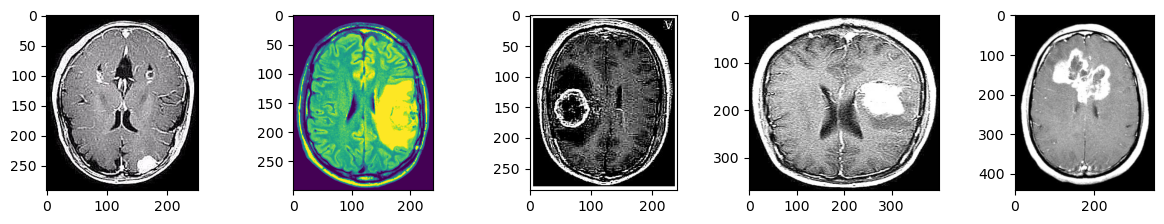


Healthy Scans:-
-----------------


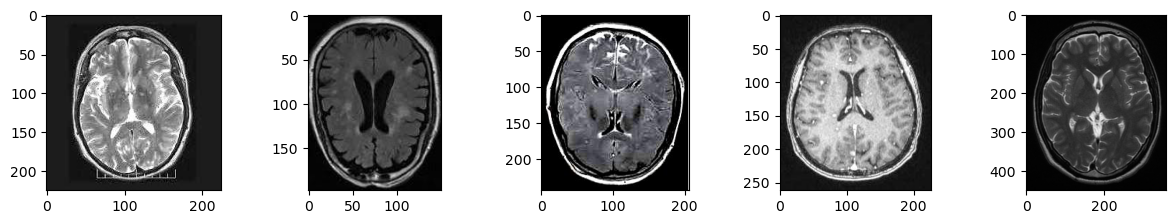

In [2]:
tumor_folder = r"D:\Mini Project\Large_dataset\yes"
healthy_folder = r"D:\Mini Project\Large_dataset\no"
tumor_listdir = os.listdir(tumor_folder)
healthy_listdir = os.listdir(healthy_folder)
print(f"No. of tumor images={len(tumor_listdir)}")
print(f"No. of healthy images={len(healthy_listdir)}")

tumor_img_extensions = list(set([img.split(".")[1] for img in tumor_listdir]))
healthy_img_extensions = list(set([img.split(".")[1] for img in healthy_listdir]))
diff_extensions = list(set(tumor_img_extensions+healthy_img_extensions))
print(f"Different extensions of images are: {diff_extensions}")
print()
print("-------------------------------------------------------------------------")
print()

# let's look at some tumorous and healthy MRI photos
def plot_photos(folder):
  images = os.listdir(folder)
  plt.subplots(figsize=(15, 5))
  # plot any 5 images
  for i in range(1,6):
    # define subplot
    plt.subplot(2,5,i)
    choice = random.randint(0,len(images)-1)
    chosenImg = images[choice]
    # define file path
    filename = folder + "/" + chosenImg
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
  # show the figure
  plt.show()
print("Tumor Scans:-")
print("-----------------")
plot_photos(tumor_folder)
print()
print("Healthy Scans:-")
print("-----------------")
plot_photos(healthy_folder)

In [3]:
# renaming properly since this is an entirely separate dataset
os.rename("D:/Mini Project/Small_dataset/no","D:/Mini Project/Small_dataset/healthy")

os.rename("D:/Mini Project/Small_dataset/yes","D:/Mini Project/Small_dataset/tumor")

In [4]:
test_tumor_listdir = os.listdir("D:/Mini Project/Small_dataset/tumor")
test_healthy_listdir = os.listdir("D:/Mini Project/Small_dataset/healthy")

print(f"No. of tumor images in test dataset={len(test_tumor_listdir)}")
print(f"No. of healthy images in test dataset={len(test_healthy_listdir)}")

No. of tumor images in test dataset=155
No. of healthy images in test dataset=98


# <font color="red">Creating Standard directories</font>

In [5]:
# moving all images (of both- tumor and healthy) together into a single temporary folder to further perform train-test split

# move tumor images first
shutil.copytree(tumor_folder, 'temp', shutil.move)

# move healthy images now
for file in healthy_listdir:
  src = healthy_folder+"/"+file
  shutil.copy(src,"temp")
  
# sanity check
print("Total No. of images in this temp folder=",len(os.listdir("temp")))

Total No. of images in this temp folder= 3000


In [6]:
#creating directories
parent = "tumor_vs_healthy/"
child_dirs = ["train/","validation/"]
for i in child_dirs:
  #create subdirectories for the 2 labels
  label_sub_dirs = ["tumor/","healthy"]
  for j in label_sub_dirs:
    newdir = parent + i + j
    os.makedirs(newdir,exist_ok=True)

# seed random number generator
random.seed(1)  # to get possible similar set of random numbers each time

# defining 80-20 ratio of train-validation split
val_ratio=0.20
# copy the images from temp folder into respective subdirectories for train and validation
src_directory = "temp"
for file in os.listdir(src_directory):
  s = src_directory + "/" + file
  dst_dir = "train/"
  if random.random() < val_ratio:
    dst_dir = "validation/"
  if file.startswith('y'):
    d = parent + dst_dir + "tumor/" + file
    shutil.copyfile(s,d)
  elif file.startswith('no') or file.startswith('No'):
    d = parent + dst_dir + "healthy/" + file
    shutil.copyfile(s,d)

In [7]:
print("Sanity for no. of images in each folder:-")
print("train")
print("healthy-->",len(os.listdir("tumor_vs_healthy/train/healthy")))
print("tumor-->",len(os.listdir("tumor_vs_healthy/train/tumor")))
print("validation")
print("healthy-->",len(os.listdir("tumor_vs_healthy/validation/healthy")))
print("tumor-->",len(os.listdir("tumor_vs_healthy/validation/tumor")))

Sanity for no. of images in each folder:-
train
healthy--> 1224
tumor--> 1179
validation
healthy--> 276
tumor--> 321


# <font color="red">EDA & Pre-processing the Data</font>

### <b><font color="#66dd11">Basic EDA</font><b>

In [11]:
# a simple EDA to get to know the height & width which have maximum no. of images
# using temp folder since all images are present here
parent = "D:/Mini Project/BrainTumor_Detection/temp/"
all_heights = []
all_widths = []
for i in os.listdir(parent):
  filename = parent + i
  image = imread(filename)
  all_heights.append(image.shape[0])
  all_widths.append(image.shape[1])

Text(0.5, 9.444444444444459, 'Height')

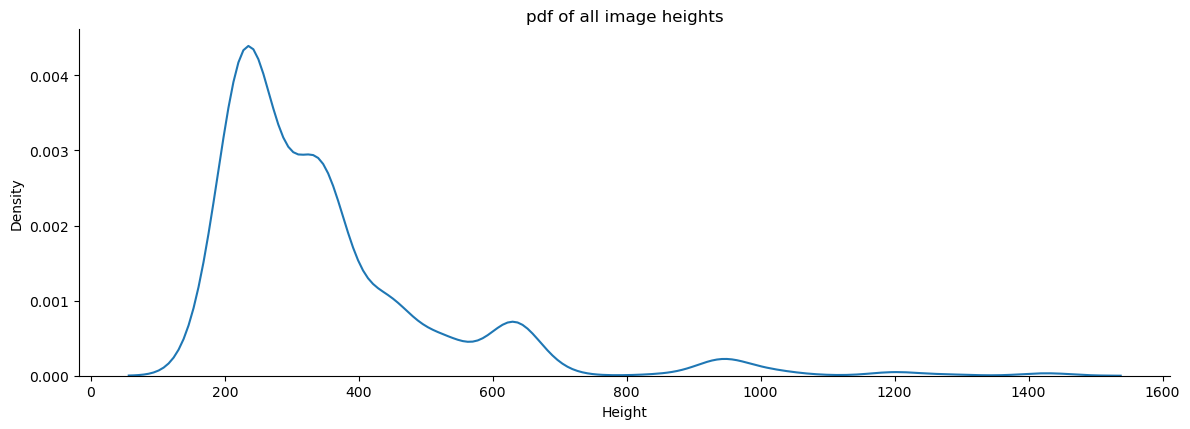

In [12]:
sns.displot(data=all_heights,kind="kde",height=4,aspect=3)
plt.title("pdf of all image heights")
plt.xlabel("Height")

Text(0.5, 9.444444444444459, 'Width')

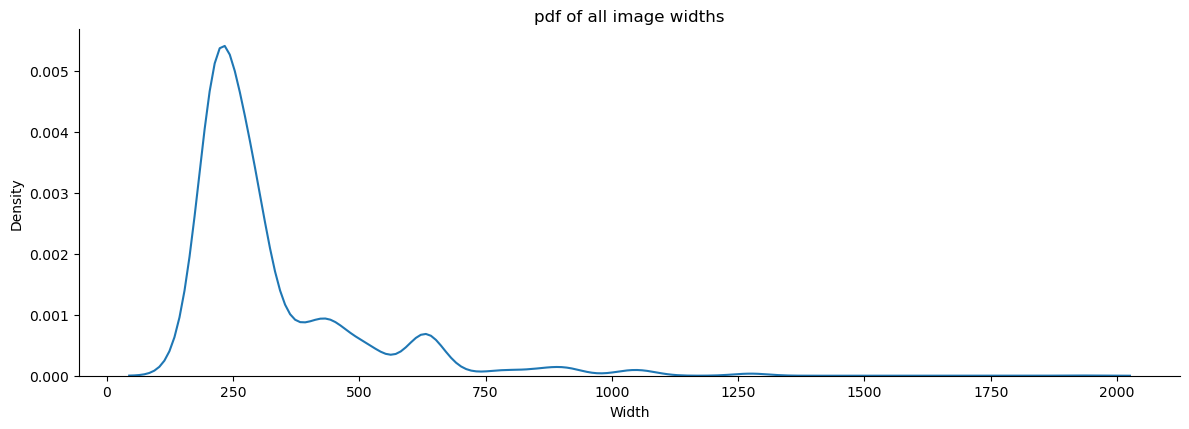

In [13]:
sns.displot(data=all_widths,kind="kde",height=4,aspect=3)
plt.title("pdf of all image widths")
plt.xlabel("Width")

In [14]:
# Most number of images have 250 as both height & width
# Hence, it will be better to keep target size of every image as (250,250) during pre-processing as shown below:-

In [15]:
# these folders are no longer required
shutil.rmtree("D:/Mini Project/Large_dataset")
shutil.rmtree("D:/Mini Project/BrainTumor_Detection/temp")

### <b><font color="#66dd11">Pre-processing</font><b>

In [16]:
BATCH_SIZE=32
TARGET_SIZE=(224,224) # since VGG16 expects this size of images

# scaling the pixel values to the range 0-1 and augmenting:-
# (note: we'll augment the train data only. Not the validation/test data)
# preprocessing_function will stay common in all 3 sets

# creating the train data generator 
datagen = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,
                              zoom_range=0.2,shear_range=0.2,horizontal_flip=True,
                              preprocessing_function=preprocess_input)

# preparing train iterator
path1 = "D:/Mini Project/BrainTumor_Detection/tumor_vs_healthy/train"
train_it = datagen.flow_from_directory(path1,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)

# creating the data generator for validation & test sets
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# preparing validation & test iterators
path2 = r"D:\Mini Project\BrainTumor_Detection\tumor_vs_healthy\validation"
validation_it = datagen.flow_from_directory(path2,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)

path3 = r"D:\Mini Project\Small_dataset"
test_it = datagen.flow_from_directory(path3,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)

print("Our data pre-processing is now done!")
print()
print("Checking the Binary Labels:-")
print(train_it.class_indices,validation_it.class_indices,test_it.class_indices)

Found 2403 images belonging to 2 classes.
Found 597 images belonging to 2 classes.
Found 253 images belonging to 2 classes.
Our data pre-processing is now done!

Checking the Binary Labels:-
{'healthy': 0, 'tumor': 1} {'healthy': 0, 'tumor': 1} {'healthy': 0, 'tumor': 1}


In [17]:
# just a sanity for deciding No. of batches or steps_per_epoch:-
print("No. of batches or steps_per_epoch for train set should be-->","2403/32=",2403/32,
      "i.e.",math.ceil(2403/32), ",which is simply", "len(train_it3)=",len(train_it))

print("No. of batches or steps_per_epoch for validation set should be-->","597/32=",597/32,
      "i.e.",math.ceil(597/32), ",which is simply", "len(validation_it3)=",len(validation_it))

No. of batches or steps_per_epoch for train set should be--> 2403/32= 75.09375 i.e. 76 ,which is simply len(train_it3)= 76
No. of batches or steps_per_epoch for validation set should be--> 597/32= 18.65625 i.e. 19 ,which is simply len(validation_it3)= 19


# <font color="red">Defining Model Architectures & Evaluation<font>

### <b><font color="#66dd11">Re-usable functions & Keras Callbacks</font><b>

In [18]:
# function for plotting diagnostic curves --> a re-usable function
def summarize_diagnostics(history):
  plt.subplot(1,2,1)
  plt.title("Epoch vs Binary Cross Entropy Loss")
  plt.plot(history.history['loss'],color="blue",label="train")
  plt.plot(history.history['val_loss'],color="orange",label="test")
  plt.xlabel("Epoch")
  plt.legend()
  plt.subplot(1,2,2)
  plt.title("Epoch vs Accuracy")
  plt.plot(history.history['accuracy'],color="blue",label="train")
  plt.plot(history.history['val_accuracy'],color="orange",label="test")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()

### <b><font color="#66dd11">Transfer Learning for Feature Extraction via VGG16 + Data Augmentation</font></b>

In [20]:
tf.keras.backend.clear_session()
# defining 1st model architecture

# loading the base-model
model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

# mark the loaded layers as not-trainable
for layer in model.layers:
  layer.trainable=False

# adding new classifier layers
flat = Flatten()(model.layers[-1].output)
classifier = Dense(units=128,activation='relu',kernel_initializer="he_uniform")(flat)
output = Dense(units=1,activation="sigmoid")(classifier)

# define the model
model = Model(inputs=model.inputs,outputs=output)

# compile the model
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

model.summary()

58889256/58889256 [==============================] - 48s 1us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                             

In [ ]:
history = model.fit(train_it,steps_per_epoch=len(train_it),
                      validation_data=validation_it,validation_steps=len(validation_it),
                      epochs=10)

Epoch 1/10
76/76 [==============================] - 230s 3s/step - loss: 0.6930 - accuracy: 0.5094 - val_loss: 0.6945 - val_accuracy: 0.4623
Epoch 2/10
76/76 [==============================] - 237s 3s/step - loss: 0.6930 - accuracy: 0.5094 - val_loss: 0.6947 - val_accuracy: 0.4623
Epoch 3/10
76/76 [==============================] - 236s 3s/step - loss: 0.6930 - accuracy: 0.5094 - val_loss: 0.6947 - val_accuracy: 0.4623
Epoch 4/10
76/76 [==============================] - 242s 3s/step - loss: 0.6930 - accuracy: 0.5094 - val_loss: 0.6949 - val_accuracy: 0.4623
Epoch 5/10
76/76 [==============================] - 240s 3s/step - loss: 0.6930 - accuracy: 0.5094 - val_loss: 0.6945 - val_accuracy: 0.4623
Epoch 6/10
23/76 [========>.....................] - ETA: 2:15 - loss: 0.6933 - accuracy: 0.5000

Scanning the diagnostics of the model performance:-


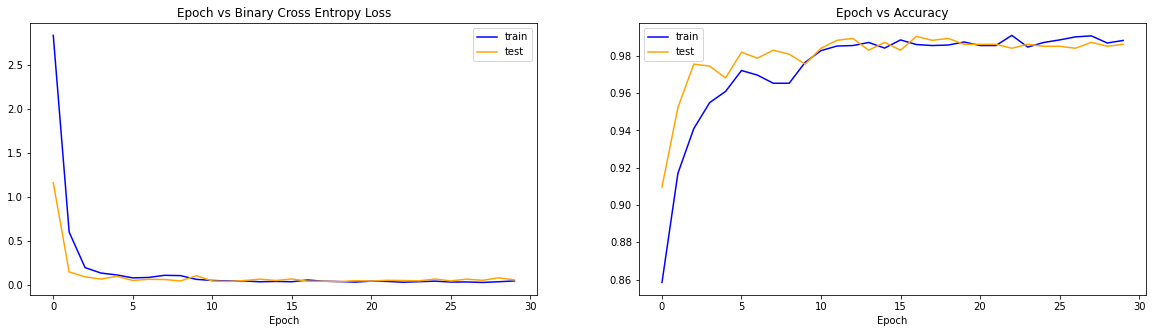

In [60]:
print("Scanning the diagnostics of the model performance:-")
plt.subplots(figsize=(20, 5))
summarize_diagnostics(history)

In [61]:
loss,acc = model.evaluate(test_it,steps=len(test_it))
print("Evaluation Accuracy on test data-set=",np.round(acc*100,3),"%")

8/8 [==============================] - 1s 104ms/step - loss: 0.0066 - accuracy: 0.9960
Evaluation Accuracy on test data-set= 99.605 %


In [63]:
model.save("D:/Mini Project/BrainTumor_Detection/save_model.h5",save_format="h5")

# <font color="red">Making a few Sample Predictions</font>

In [66]:
def predict_tumor(img_path):
    # load the image
    img = load_img(img_path, target_size=(224, 224))  #(224,224,3)
    plt.imshow(img)
    
    # convert to array
    img = img_to_array(img) #(224,224,3)
    
    # add batch size as a dimension 
    img = np.expand_dims(img, axis=0)  #(1,224,224,3)
    best = load_model("D:/Mini Project/BrainTumor_Detection/save_model.h5")
    if best.predict(img)[0][0]>0.4:
        print("The image indicates presence of Brain tumor")
    else:
        print("This is a Healthy Brain")
    print("Probability of classfication:",best.predict(img)[0][0])

The image indicates presence of Brain tumor
Probability of classfication: 1.0


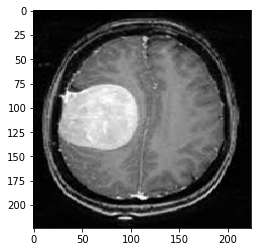

In [67]:
predict_tumor(r"D:\Mini Project\Pred\pred1")

This is a Healthy Brain
Probability of classfication: 6.1865553e-06


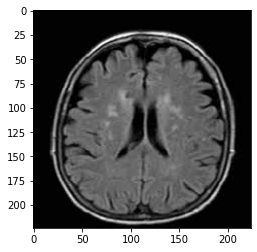

In [68]:
predict_tumor(r"D:\Mini Project\Pred\pred2")

The image indicates presence of Brain tumor
Probability of classfication: 1.0


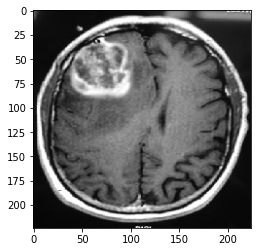

In [69]:
predict_tumor(r"D:\Mini Project\Pred\pred3")

The image indicates presence of Brain tumor
Probability of classfication: 0.9999076


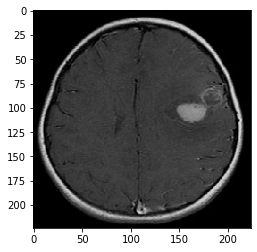

In [70]:
predict_tumor(r"D:\Mini Project\Pred\pred4")